In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (1153).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (352).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (179).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (672).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (501).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (405).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (436).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (883).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (564).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (936).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (837).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (421).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (1031).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVID/Non-Covid (221).png
/kaggle/input/sarscov2-ctscan-dataset/non-COVI

## Setup

In [2]:
# Setup

import time
import os
import copy
import torch
import torchvision
import zipfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torchvision.io as io
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.datasets.utils import download_url
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torch.utils.data import TensorDataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision import datasets, models, transforms
from PIL import Image
import torchvision.transforms.functional as TF
import torch.optim as opt
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
import itertools
from tqdm.notebook import tqdm
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

## Data

In [3]:
Data_Directory="../input/sarscov2-ctscan-dataset"

# Data directory and classes
data_dir="../input/sarscov2-ctscan-dataset"

print("Folders in Data set : ",os.listdir(data_dir))
classes=os.listdir(data_dir)
print("Classes : ",classes)



print("abnormal images : ",len(os.listdir(data_dir+'/COVID')))
print("normal images : ",len(os.listdir(data_dir+'/non-COVID')))

Folders in Data set :  ['non-COVID', 'COVID']
Classes :  ['non-COVID', 'COVID']
abnormal images :  1252
normal images :  1229


In [4]:
## Split into train,val,test

!pip install split-folders

In [5]:
import splitfolders
splitfolders.ratio(data_dir,output="output",seed=1337 ,ratio=(.9,.1))

Copying files: 2481 files [00:16, 151.67 files/s]


In [6]:
whole_train="./output/train"
splitfolders.ratio(whole_train,output="./output/train-val",seed=1337 ,ratio=(.9,.1))

Copying files: 2232 files [00:00, 4611.06 files/s]


In [7]:
train_ds_path="./output/train-val/train"
val_ds_path="./output/train-val/val"
test_ds_path="./output/val"
full_ds_path="./output/train"



print("train images : ",len(os.listdir(train_ds_path+'/COVID'))+len(os.listdir(train_ds_path+'/non-COVID')))
print("val images : ",len(os.listdir(val_ds_path+'/COVID'))+len(os.listdir(val_ds_path+'/non-COVID')))
print("test images : ",len(os.listdir(test_ds_path+'/COVID'))+len(os.listdir(test_ds_path+'/non-COVID')))
print("whole training images : ",len(os.listdir(full_ds_path+'/COVID'))+len(os.listdir(full_ds_path+'/non-COVID')))

print("\n")
print("abnormal train images : ",len(os.listdir(train_ds_path+'/COVID')))
print("abnormal val images : ",len(os.listdir(val_ds_path+'/COVID')))
print("abnormal test images : ",len(os.listdir(test_ds_path+'/COVID')))
print("abnormal whole training images : ",len(os.listdir(full_ds_path+'/COVID')))
print("\n")
print("normal train images : ",len(os.listdir(train_ds_path+'/non-COVID')))
print("normal val images : ",len(os.listdir(val_ds_path+'/non-COVID')))
print("normal test images : ",len(os.listdir(test_ds_path+'/non-COVID')))
print("normal whole training images : ",len(os.listdir(full_ds_path+'/non-COVID')))

train images :  2008
val images :  224
test images :  249
whole training images :  2232


abnormal train images :  1013
abnormal val images :  113
abnormal test images :  126
abnormal whole training images :  1126


normal train images :  995
normal val images :  111
normal test images :  123
normal whole training images :  1106


In [8]:
# Data transforms (normalization & data augmentation)
# Initially PIL Images
# ToTensor: convert PIL Image to tensor and values normalized 0 to 1
train_tfms = tt.Compose([
                         tt.Resize((224,224)),
                        #  tt.RandomRotation(degrees=(-20,20)),
                         tt.ToTensor()])
val_tfms = tt.Compose([
                       tt.Resize((224,224)),
                         tt.ToTensor()])
test_tfms = tt.Compose([
                        tt.Resize((224,224)),
                         tt.ToTensor()])

### Datasets

In [9]:
train_ds=ImageFolder(train_ds_path, transform=train_tfms)
val_ds=ImageFolder(val_ds_path, transform=val_tfms)
test_ds=ImageFolder(test_ds_path, transform=test_tfms)
full_ds=ImageFolder(full_ds_path, transform=train_tfms)
# test_dataset=test_ds

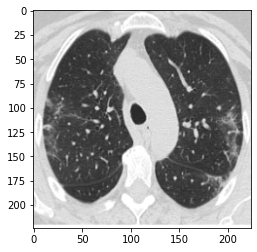

In [10]:
for img,label in train_ds:
  img=img.squeeze_()
  img=img.permute(1,2,0)
  plt.imshow(img,cmap="gray")
  break

### Data Loader

In [11]:
batch_size = 20
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=3, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, num_workers=3, pin_memory=True)
# test_dataloader=test_dl

## Model

### GPU

In [12]:
### GPU

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

### Plotting

In [13]:
def plot_confusion_matrix(data_loader,nb_classes):
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    y_pred=[]
    y_true=[]
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(val_dl):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            outs=preds.detach().cpu().numpy()
            classess=classes.detach().cpu().numpy()
            y_pred=np.concatenate((y_pred,outs),axis=None)
            y_true=np.concatenate((y_true,classess),axis=None)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
    array=confusion_matrix(y_pred,y_true)
    classes=os.listdir(data_dir)
    df_cm = pd.DataFrame(array, index =classes,
                  columns = classes)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True,cmap='Blues',fmt='g')

### Resnet-152

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item(),dtype=torch.float32)


class ImageClassificationBase(nn.Module):
    def training_step(self,batch, loss_func):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = loss_func(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch,loss_func):
        images, labels = batch
        out = self(images)                    # Generate predictions
        # print("out : ",out)
        # print("labels : ",labels)
        loss = loss_func(out, labels)   # Calculate loss
        crct_pred = accuracy(out, labels)           # Calculate accuracy
        # print("crct_pred ",crct_pred," batch_size : ",20)
        return {'val_loss': loss.detach(), 'crct_pred': crct_pred, 'batch_size' : len(images)}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_sizes=[x['batch_size'] for x in outputs]
        net_size=sum(batch_sizes)
        crct_preds = [x['crct_pred'] for x in outputs]
        epoch_acc = sum(crct_preds)/net_size
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))
    def pred(self,img):
      out=self(img)
      return out
    def predictions(self,images):
      outputs=self(images)
      _, preds = torch.max(outputs, dim=1)
      return preds


In [15]:
@torch.no_grad()
def evaluate(model, val_loader,loss_func):
    model.eval()
    outputs = [model.validation_step(batch,loss_func) for batch in val_loader]
    
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader,loss_func, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch,loss_func)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader,loss_func)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None,loss_func=F.cross_entropy, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up cosine annealing lr learning rate scheduler
    count=0
    for batch in tqdm(train_loader):
      count=count+1
    num_iter=count*epochs
    sched=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=num_iter,
                                                     eta_min=0.00001)

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch,loss_func)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader,loss_func)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [16]:
device = get_default_device()
device

device(type='cuda')

In [17]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

#### With Freezing

In [18]:
class RESNET_152(ImageClassificationBase):
    def __init__(self, num_classes,pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet152(pretrained=pretrained)
        # Freeze model weigths
        for param in self.network.parameters():
            param.requires_grad=False
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)
        for param in self.network.fc.parameters():
          param.requires_grad = True
          
    def forward(self, xb):
        return self.network(xb)

##### Cross Entropy

In [19]:
# Parameters
num_classes=2
epochs = 20
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
loss_func=F.cross_entropy

# Model
model=RESNET_152(num_classes)
to_device(model,device)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

RESNET_152(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

In [20]:
torch.manual_seed(42)
k=5
num_epochs = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
splits=KFold(n_splits=k,shuffle=True,random_state=42)
foldperf={}

In [21]:
def train_epoch(model,device,dataloader,scheduler,loss_fn=F.cross_entropy,optimizer=torch.optim.Adam,grad_clip=0):

    train_loss,train_correct=0.0,0
    model.train()
    for images, labels in dataloader:

        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output,labels)
        loss.backward()
        if grad_clip:
          nn.utils.clip_grad_value_(model.parameters(), grad_clip)
        optimizer.step()
        scheduler.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss,train_correct
  
def valid_epoch(model,num_classes,device,dataloader,loss_fn=F.cross_entropy,grad_clip=0):
  valid_loss, val_correct = 0.0, 0
  y_true=[]
  y_pred=[]
  model.eval()
  for images, labels in dataloader:

      images,labels = images.to(device),labels.to(device)
      output = model(images)
      loss=loss_fn(output,labels)
      valid_loss+=loss.item()*images.size(0)
      scores, predictions = torch.max(output.data,1)
      val_correct+=(predictions == labels).sum().item()
      predictions=predictions.detach().cpu().tolist()
      labels=labels.detach().cpu().tolist()
      y_pred.extend(predictions)
      y_true.extend(labels)

  array=confusion_matrix(y_pred,y_true)
  classes=os.listdir(data_dir)
  df_cm = pd.DataFrame(array, index =classes,
                  columns = classes)
  plt.figure(figsize = (10,7))
  sn.heatmap(df_cm, annot=True,cmap='Blues',fmt='g')
  plt.show()
  
  return valid_loss,val_correct

def cross_validate(model,num_classes,full_ds,opt_func,loss_func,grad_clip):
  foldperf={}
  for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(full_ds)))):

      print('Fold {}'.format(fold + 1))

      train_sampler = SubsetRandomSampler(train_idx)
      test_sampler = SubsetRandomSampler(val_idx)
      train_loader = DataLoader(full_ds, batch_size=batch_size, sampler=train_sampler)
      test_loader = DataLoader(full_ds, batch_size=batch_size, sampler=test_sampler)
    
      device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
      model.to(device)
      print(loss_func)
      optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
      # Set up cosine annealing lr learning rate scheduler
      count=0
      for batch in tqdm(train_loader):
        count=count+1
      num_iter=count*num_epochs
      sched=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=num_iter,
                                                     eta_min=0.00001)

      history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

      for epoch in range(num_epochs):
          train_loss, train_correct=train_epoch(model,device,train_loader,sched,loss_func,optimizer,grad_clip)
          test_loss, test_correct=valid_epoch(model,num_classes,device,test_loader,loss_func,grad_clip)

          train_loss = train_loss / len(train_loader.sampler)
          train_acc = train_correct / len(train_loader.sampler) * 100
          test_loss = test_loss / len(test_loader.sampler)
          test_acc = test_correct / len(test_loader.sampler) * 100

          print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             test_loss,
                                                                                                             train_acc,
                                                                                                             test_acc))
          history['train_loss'].append(train_loss)
          history['test_loss'].append(test_loss)
          history['train_acc'].append(train_acc)
          history['test_acc'].append(test_acc)
      
      foldperf['fold{}'.format(fold+1)] = history  

  torch.save(model,'k_cross_CNN.pt')
  return foldperf


def test(model,device,dataloader,test_dataset,loss_fn=F.cross_entropy):
  test_loss, test_correct = 0.0, 0
  model.eval()
  y_true=[]
  y_pred=[]
  for images, labels in dataloader:

      images,labels = images.to(device),labels.to(device)
      output = model(images)
      loss=loss_fn(output,labels)
      test_loss+=loss.item()*images.size(0)
      scores, predictions = torch.max(output.data,1)
      test_correct+=(predictions == labels).sum().item()
      predictions=predictions.detach().cpu().tolist()
      labels=labels.detach().cpu().tolist()
      y_pred.extend(predictions)
      y_true.extend(labels)
    
  test_loss = test_loss / len(test_dataset)
  test_acc = test_correct / len(test_dataset) * 100
  array=confusion_matrix(y_pred,y_true)
  classes=os.listdir(data_dir)
  df_cm = pd.DataFrame(array, index =classes,
                  columns = classes)
  plt.figure(figsize = (10,7))
  sn.heatmap(df_cm, annot=True,cmap='Blues',fmt='g')
  plt.show()

  return test_loss,test_acc



def cv_results(foldperf):
  testl_f,tl_f,testa_f,ta_f=[],[],[],[]
  testl_fm,tl_fm,testa_fm,ta_fm=[],[],[],[]
  for f in range(1,k+1):

      tl_f.append(np.mean(foldperf['fold{}'.format(f)]['train_loss']))
      testl_f.append(np.mean(foldperf['fold{}'.format(f)]['test_loss']))

      ta_f.append(np.mean(foldperf['fold{}'.format(f)]['train_acc']))
      testa_f.append(np.mean(foldperf['fold{}'.format(f)]['test_acc']))
      tl_fm.append(np.max(foldperf['fold{}'.format(f)]['train_loss']))
      testl_fm.append(np.max(foldperf['fold{}'.format(f)]['test_loss']))

      ta_fm.append(np.max(foldperf['fold{}'.format(f)]['train_acc']))
      testa_fm.append(np.max(foldperf['fold{}'.format(f)]['test_acc']))

  print('Performance of {} fold cross validation'.format(k))
  print("Average Training Loss: {:.3f} \t Average val Loss: {:.3f} \t Average Training Acc: {:.2f} \t Average val Acc: {:.2f}".format(np.mean(tl_f),np.mean(testl_f),np.mean(ta_f),np.mean(testa_f)))  
  print("Max Training Acc: {:.2f} \t Max val Acc: {:.2f}".format(np.max(ta_fm),np.max(testa_fm)))  

Fold 1
<function cross_entropy at 0x7f6e1ed29ef0>


  0%|          | 0/90 [00:00<?, ?it/s]

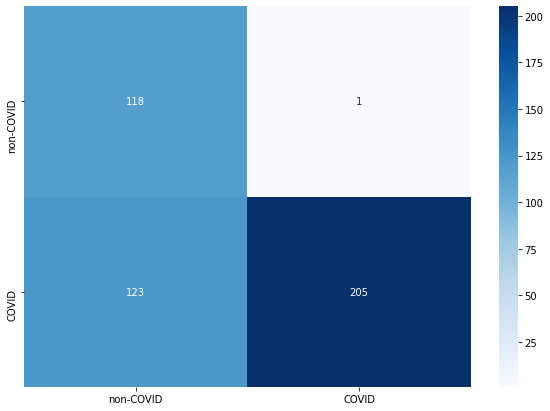

Epoch:1/10 AVG Training Loss:0.772 AVG Test Loss:0.780 AVG Training Acc 74.06 % AVG Test Acc 72.26 %


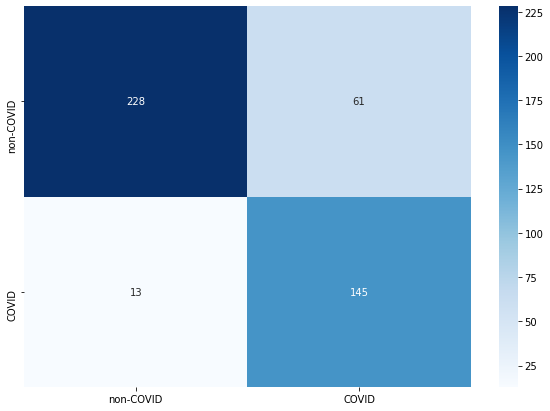

Epoch:2/10 AVG Training Loss:0.700 AVG Test Loss:0.432 AVG Training Acc 76.08 % AVG Test Acc 83.45 %


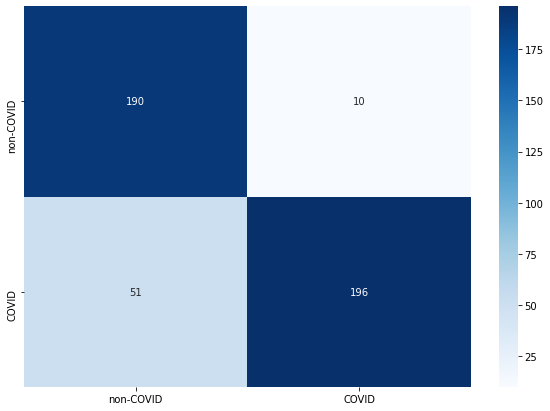

Epoch:3/10 AVG Training Loss:0.329 AVG Test Loss:0.382 AVG Training Acc 85.83 % AVG Test Acc 86.35 %


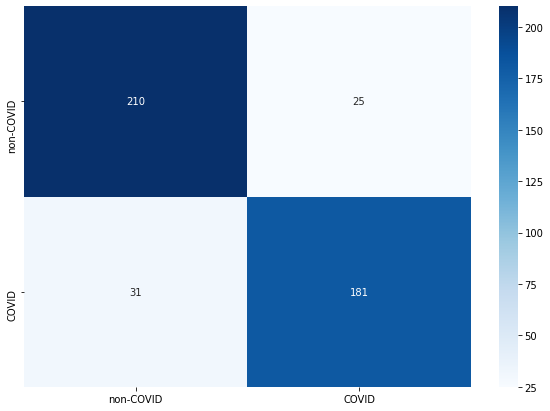

Epoch:4/10 AVG Training Loss:0.528 AVG Test Loss:0.310 AVG Training Acc 80.67 % AVG Test Acc 87.47 %


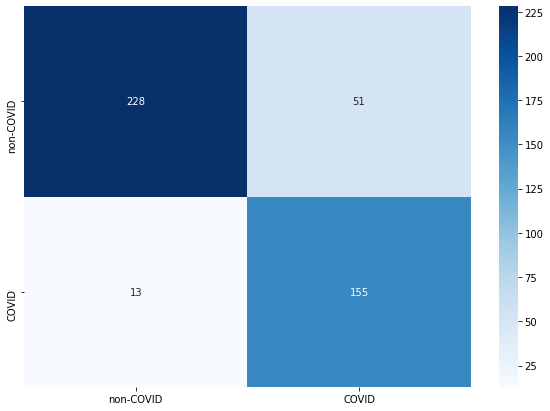

Epoch:5/10 AVG Training Loss:0.302 AVG Test Loss:0.374 AVG Training Acc 88.57 % AVG Test Acc 85.68 %


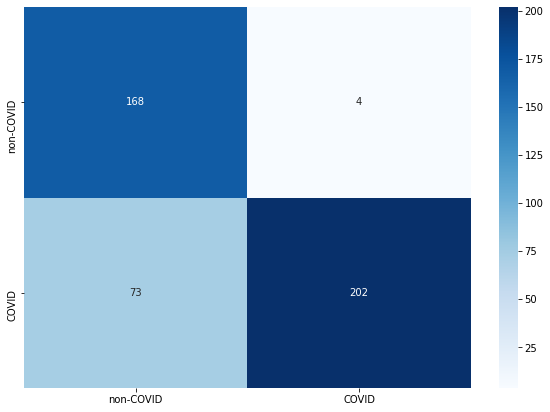

Epoch:6/10 AVG Training Loss:0.273 AVG Test Loss:0.503 AVG Training Acc 88.91 % AVG Test Acc 82.77 %


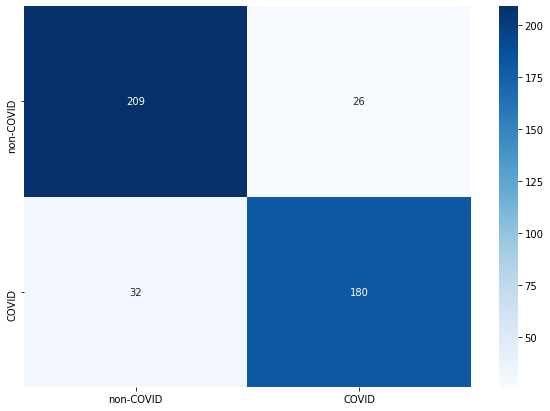

Epoch:7/10 AVG Training Loss:0.235 AVG Test Loss:0.283 AVG Training Acc 90.59 % AVG Test Acc 87.02 %


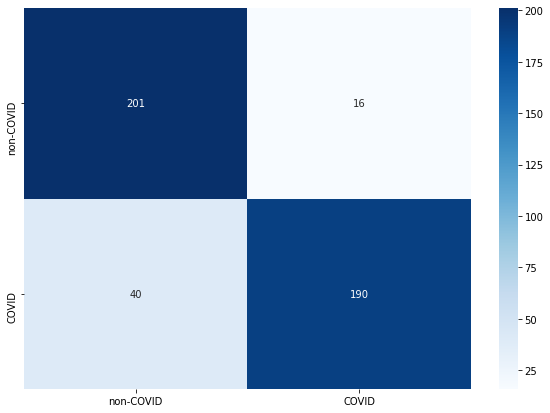

Epoch:8/10 AVG Training Loss:0.201 AVG Test Loss:0.299 AVG Training Acc 91.76 % AVG Test Acc 87.47 %


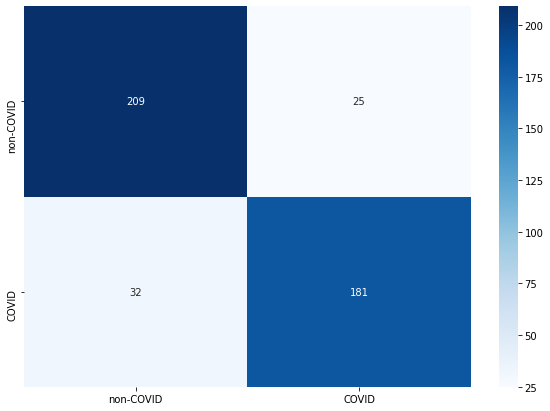

Epoch:9/10 AVG Training Loss:0.188 AVG Test Loss:0.273 AVG Training Acc 92.04 % AVG Test Acc 87.25 %


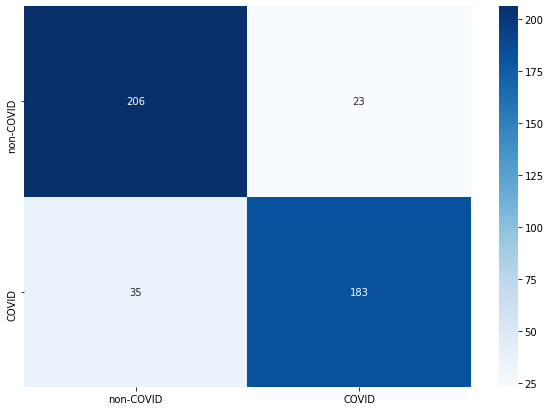

Epoch:10/10 AVG Training Loss:0.166 AVG Test Loss:0.274 AVG Training Acc 93.61 % AVG Test Acc 87.02 %
Fold 2
<function cross_entropy at 0x7f6e1ed29ef0>


  0%|          | 0/90 [00:00<?, ?it/s]

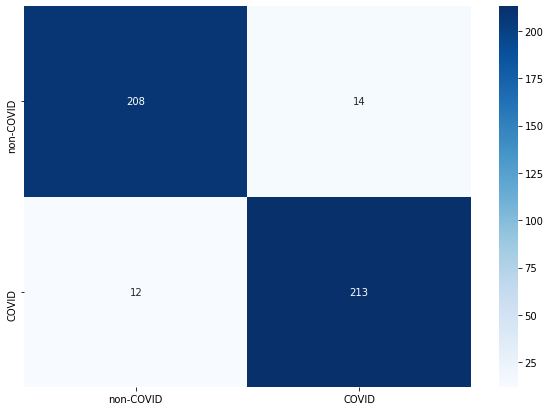

Epoch:1/10 AVG Training Loss:0.869 AVG Test Loss:0.157 AVG Training Acc 77.82 % AVG Test Acc 94.18 %


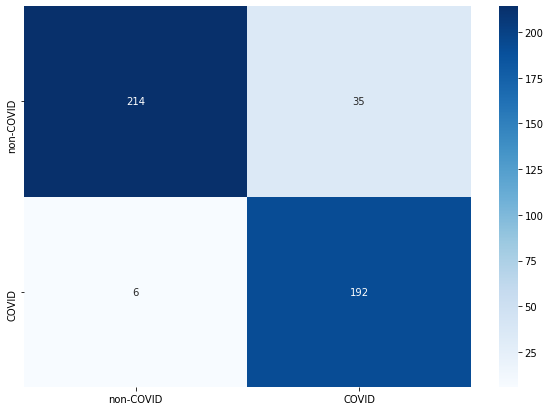

Epoch:2/10 AVG Training Loss:0.493 AVG Test Loss:0.234 AVG Training Acc 83.19 % AVG Test Acc 90.83 %


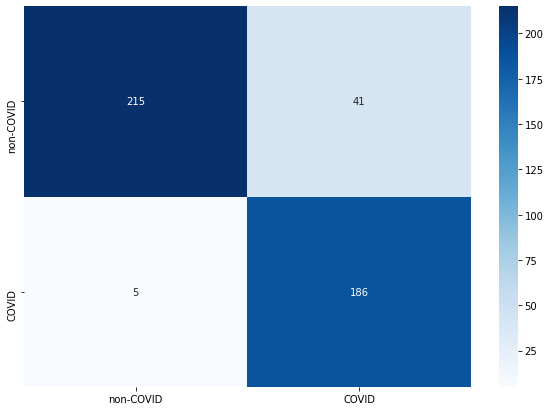

Epoch:3/10 AVG Training Loss:0.456 AVG Test Loss:0.249 AVG Training Acc 83.70 % AVG Test Acc 89.71 %


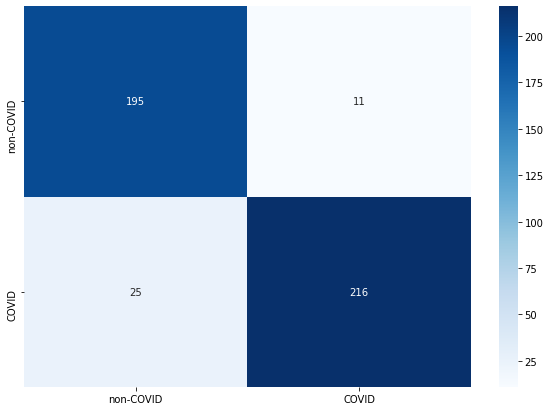

Epoch:4/10 AVG Training Loss:0.284 AVG Test Loss:0.187 AVG Training Acc 89.19 % AVG Test Acc 91.95 %


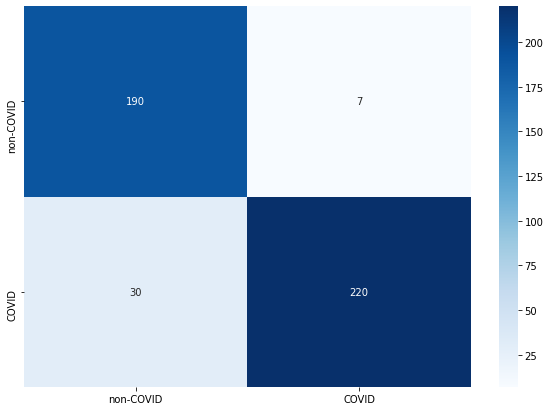

Epoch:5/10 AVG Training Loss:0.287 AVG Test Loss:0.198 AVG Training Acc 88.63 % AVG Test Acc 91.72 %


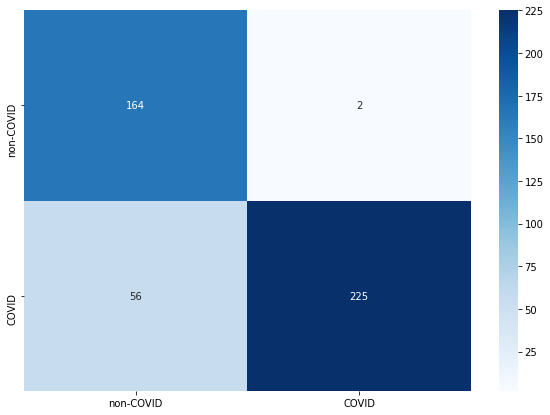

Epoch:6/10 AVG Training Loss:0.295 AVG Test Loss:0.419 AVG Training Acc 88.18 % AVG Test Acc 87.02 %


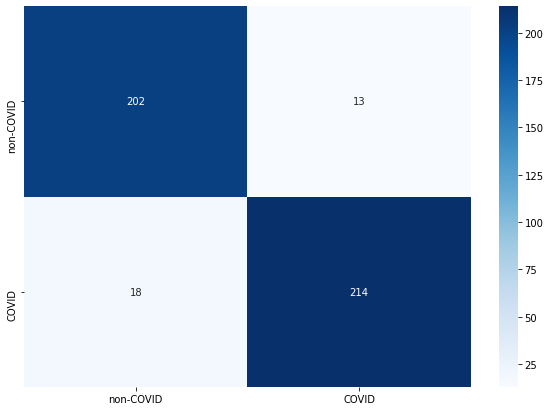

Epoch:7/10 AVG Training Loss:0.213 AVG Test Loss:0.184 AVG Training Acc 92.27 % AVG Test Acc 93.06 %


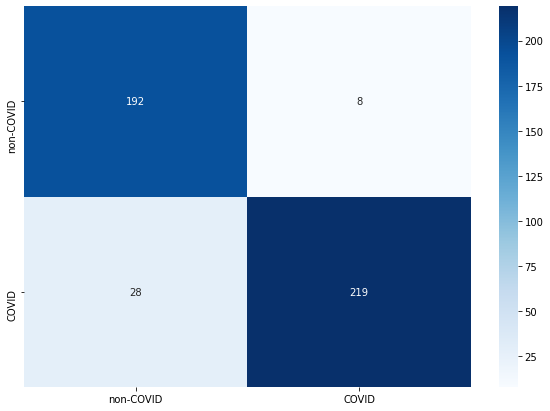

Epoch:8/10 AVG Training Loss:0.216 AVG Test Loss:0.201 AVG Training Acc 91.26 % AVG Test Acc 91.95 %


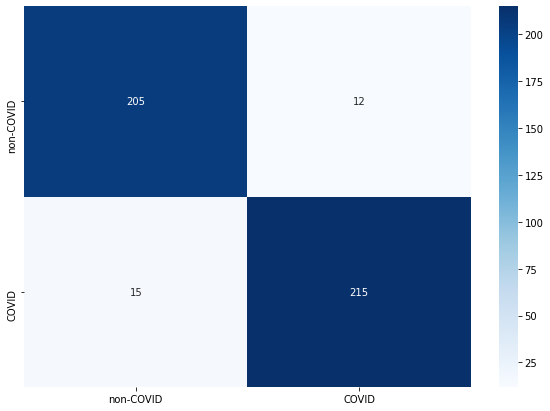

Epoch:9/10 AVG Training Loss:0.191 AVG Test Loss:0.172 AVG Training Acc 92.10 % AVG Test Acc 93.96 %


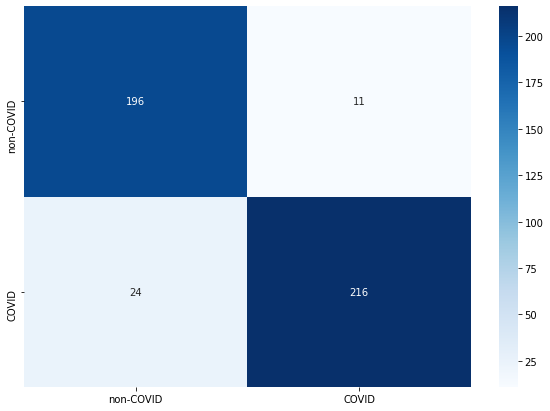

Epoch:10/10 AVG Training Loss:0.181 AVG Test Loss:0.179 AVG Training Acc 92.38 % AVG Test Acc 92.17 %
Fold 3
<function cross_entropy at 0x7f6e1ed29ef0>


  0%|          | 0/90 [00:00<?, ?it/s]

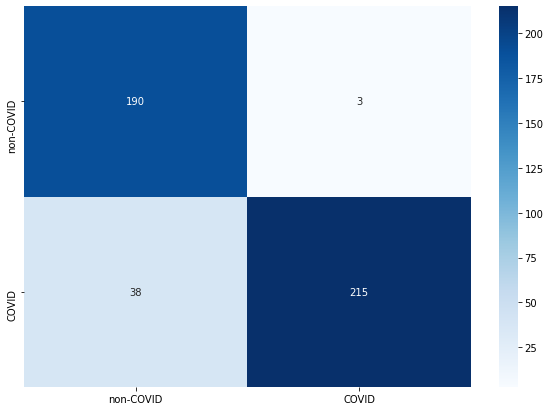

Epoch:1/10 AVG Training Loss:0.769 AVG Test Loss:0.231 AVG Training Acc 79.68 % AVG Test Acc 90.81 %


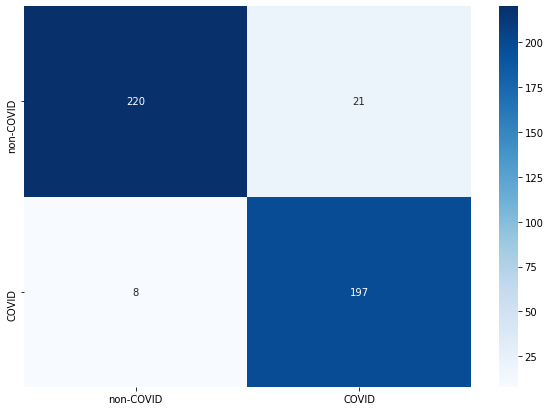

Epoch:2/10 AVG Training Loss:0.564 AVG Test Loss:0.179 AVG Training Acc 83.71 % AVG Test Acc 93.50 %


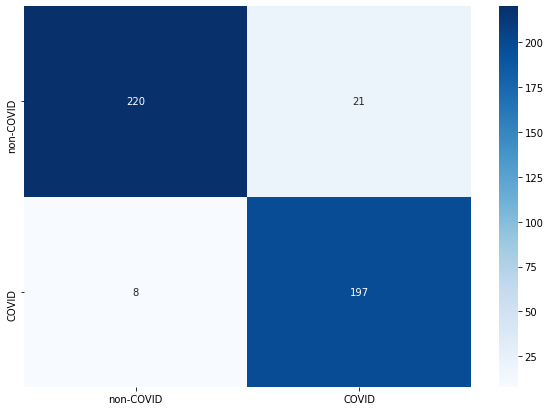

Epoch:3/10 AVG Training Loss:0.434 AVG Test Loss:0.180 AVG Training Acc 85.67 % AVG Test Acc 93.50 %


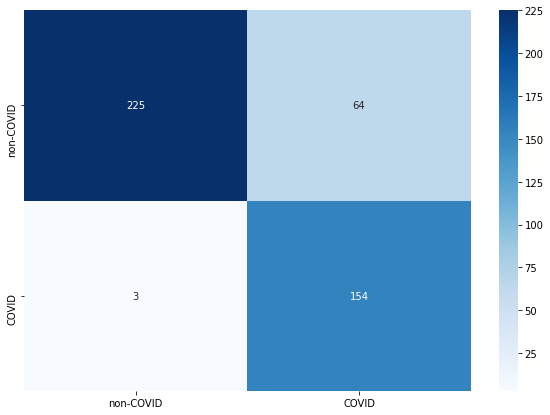

Epoch:4/10 AVG Training Loss:0.279 AVG Test Loss:0.388 AVG Training Acc 90.48 % AVG Test Acc 84.98 %


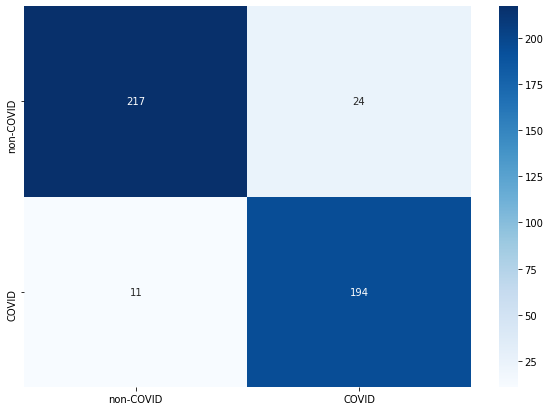

Epoch:5/10 AVG Training Loss:0.385 AVG Test Loss:0.186 AVG Training Acc 86.56 % AVG Test Acc 92.15 %


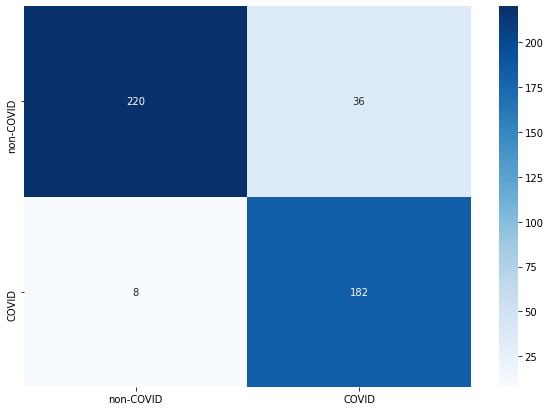

Epoch:6/10 AVG Training Loss:0.260 AVG Test Loss:0.256 AVG Training Acc 90.09 % AVG Test Acc 90.13 %


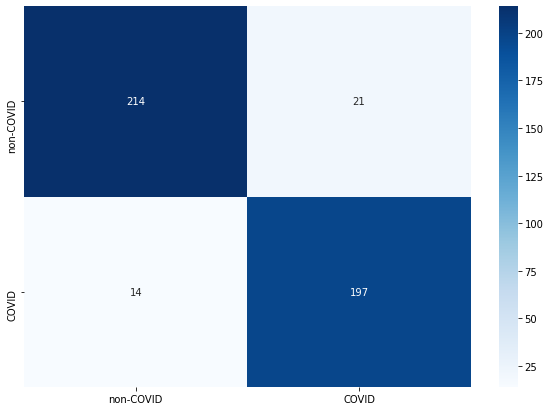

Epoch:7/10 AVG Training Loss:0.202 AVG Test Loss:0.197 AVG Training Acc 91.99 % AVG Test Acc 92.15 %


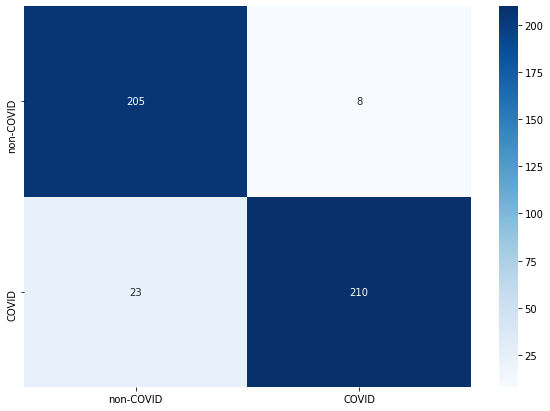

Epoch:8/10 AVG Training Loss:0.220 AVG Test Loss:0.200 AVG Training Acc 91.32 % AVG Test Acc 93.05 %


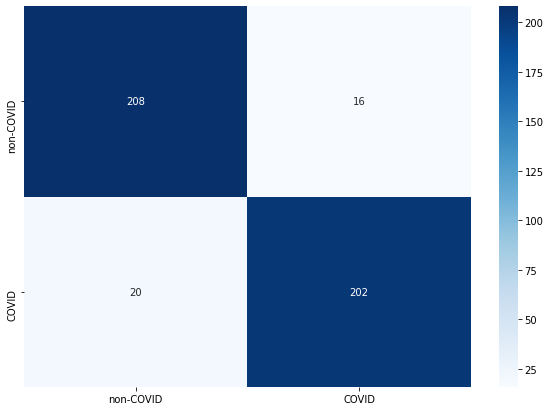

Epoch:9/10 AVG Training Loss:0.176 AVG Test Loss:0.195 AVG Training Acc 92.61 % AVG Test Acc 91.93 %


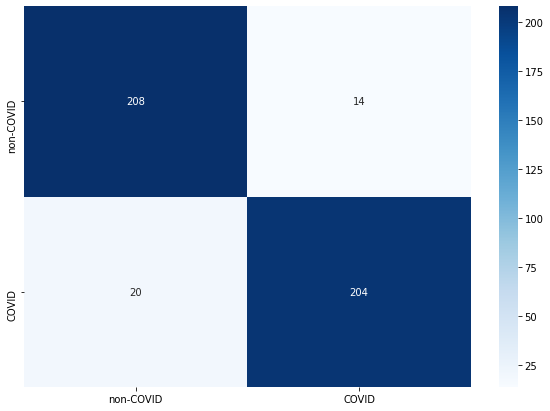

Epoch:10/10 AVG Training Loss:0.170 AVG Test Loss:0.190 AVG Training Acc 92.72 % AVG Test Acc 92.38 %
Fold 4
<function cross_entropy at 0x7f6e1ed29ef0>


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:1/10 AVG Training Loss:0.632 AVG Test Loss:0.107 AVG Training Acc 83.09 % AVG Test Acc 95.52 %


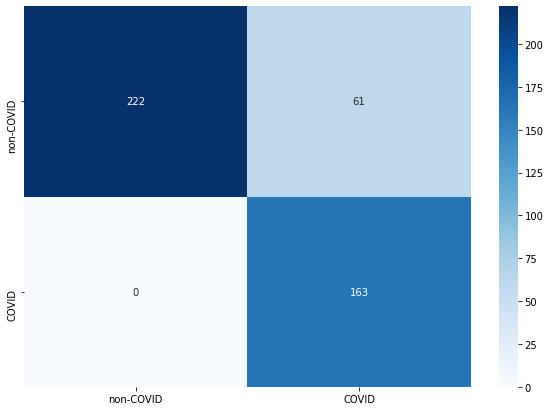

Epoch:2/10 AVG Training Loss:0.403 AVG Test Loss:0.378 AVG Training Acc 86.28 % AVG Test Acc 86.32 %


Epoch:3/10 AVG Training Loss:0.303 AVG Test Loss:0.345 AVG Training Acc 90.03 % AVG Test Acc 86.77 %


Epoch:4/10 AVG Training Loss:0.348 AVG Test Loss:0.119 AVG Training Acc 88.52 % AVG Test Acc 95.52 %


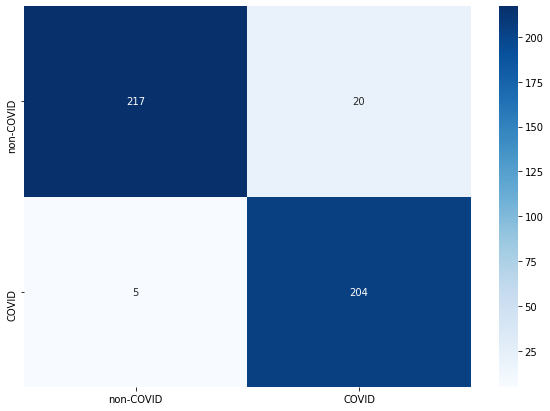

Epoch:5/10 AVG Training Loss:0.479 AVG Test Loss:0.150 AVG Training Acc 86.67 % AVG Test Acc 94.39 %


Epoch:6/10 AVG Training Loss:0.281 AVG Test Loss:0.601 AVG Training Acc 89.19 % AVG Test Acc 80.27 %


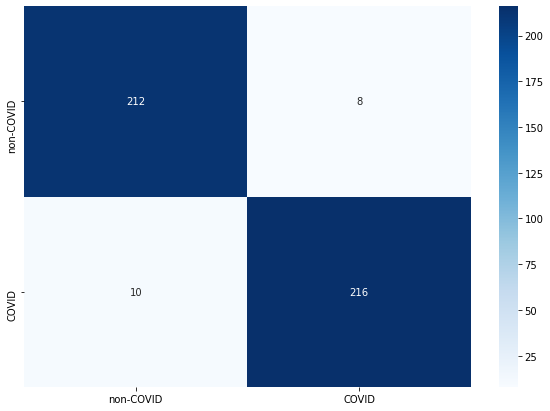

Epoch:7/10 AVG Training Loss:0.232 AVG Test Loss:0.101 AVG Training Acc 90.99 % AVG Test Acc 95.96 %


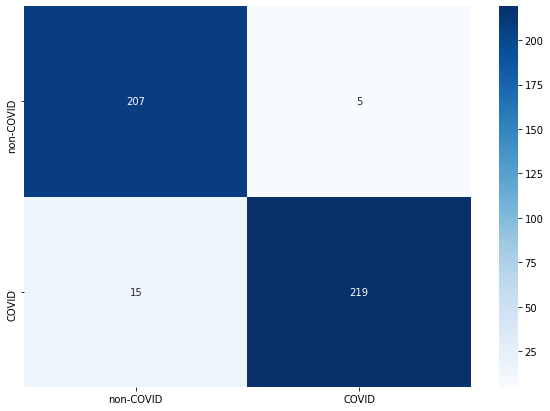

Epoch:8/10 AVG Training Loss:0.154 AVG Test Loss:0.121 AVG Training Acc 93.90 % AVG Test Acc 95.52 %


Epoch:9/10 AVG Training Loss:0.151 AVG Test Loss:0.107 AVG Training Acc 93.56 % AVG Test Acc 95.96 %


Epoch:10/10 AVG Training Loss:0.159 AVG Test Loss:0.120 AVG Training Acc 93.67 % AVG Test Acc 94.62 %
Fold 5
<function cross_entropy at 0x7f6e1ed29ef0>


  0%|          | 0/90 [00:00<?, ?it/s]

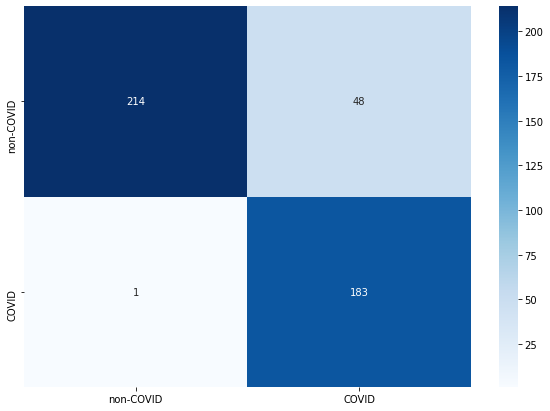

Epoch:1/10 AVG Training Loss:0.925 AVG Test Loss:0.332 AVG Training Acc 79.45 % AVG Test Acc 89.01 %


Epoch:2/10 AVG Training Loss:0.464 AVG Test Loss:0.262 AVG Training Acc 86.28 % AVG Test Acc 91.93 %


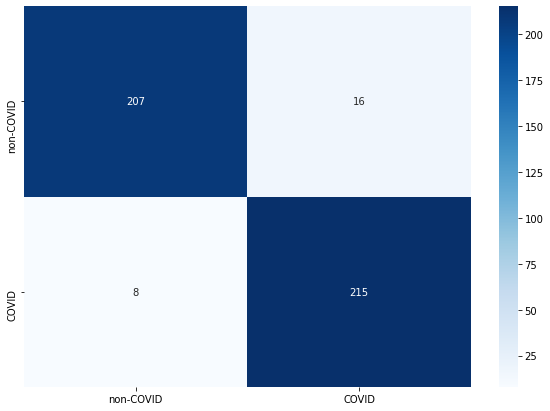

Epoch:3/10 AVG Training Loss:0.344 AVG Test Loss:0.135 AVG Training Acc 88.63 % AVG Test Acc 94.62 %


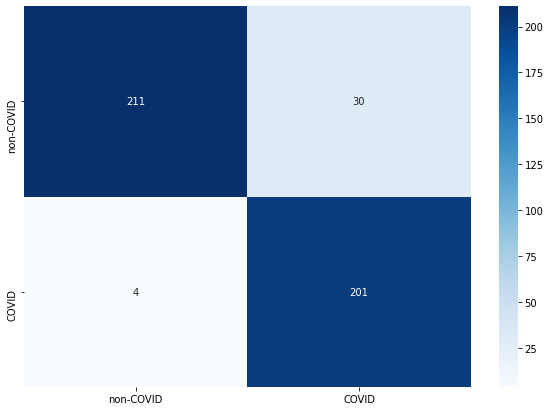

Epoch:4/10 AVG Training Loss:0.297 AVG Test Loss:0.181 AVG Training Acc 90.20 % AVG Test Acc 92.38 %


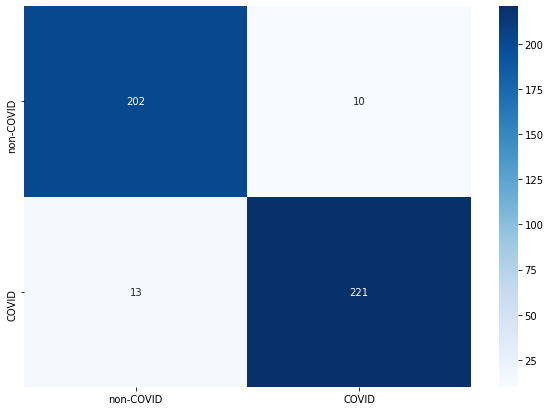

Epoch:5/10 AVG Training Loss:0.381 AVG Test Loss:0.143 AVG Training Acc 86.62 % AVG Test Acc 94.84 %


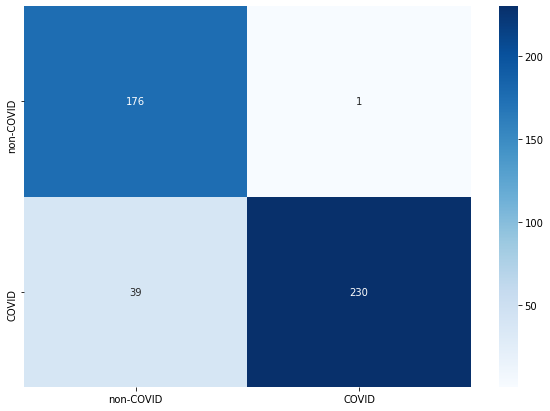

Epoch:6/10 AVG Training Loss:0.250 AVG Test Loss:0.270 AVG Training Acc 91.66 % AVG Test Acc 91.03 %


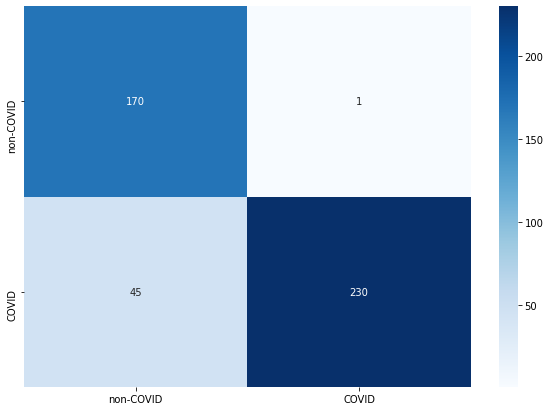

Epoch:7/10 AVG Training Loss:0.202 AVG Test Loss:0.332 AVG Training Acc 93.00 % AVG Test Acc 89.69 %


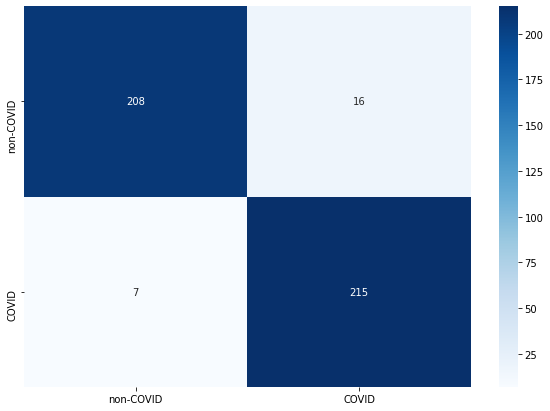

Epoch:8/10 AVG Training Loss:0.172 AVG Test Loss:0.135 AVG Training Acc 93.62 % AVG Test Acc 94.84 %


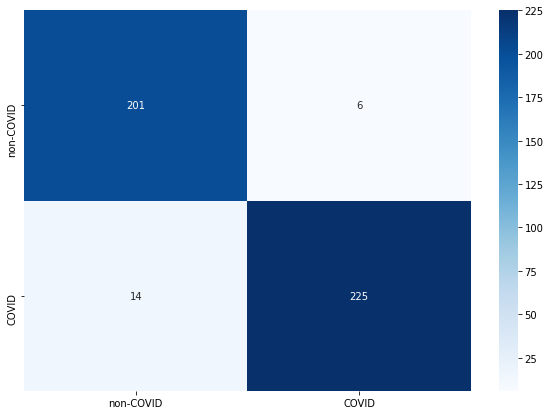

Epoch:9/10 AVG Training Loss:0.141 AVG Test Loss:0.129 AVG Training Acc 94.62 % AVG Test Acc 95.52 %


Epoch:10/10 AVG Training Loss:0.125 AVG Test Loss:0.126 AVG Training Acc 94.85 % AVG Test Acc 95.52 %


In [22]:
folderperf=cross_validate(model,num_classes,full_ds,opt_func,loss_func,grad_clip)

In [23]:
print("Resnet-152  With Freezing Cross Entropy+CV ")
cv_results(folderperf)

Resnet-152  With Freezing Cross Entropy+CV 
Performance of 5 fold cross validation
Average Training Loss: 0.342 	 Average val Loss: 0.250 	 Average Training Acc: 88.41 	 Average val Acc: 90.56
Max Training Acc: 94.85 	 Max val Acc: 95.96


In [24]:
def fold_plot(folderperf,num_rows,suptitle,num_cols=2):
  fig, axes = plt.subplots(num_rows, num_cols,figsize=(15, 15))
  fig.suptitle(suptitle,fontsize=16,y=1.02)
  for fold in range(1,num_rows+1):
    fold_results=folderperf['fold'+str(fold)]
    # 'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]
    train_loss=fold_results['train_loss']
    test_loss=fold_results['test_loss']
    train_acc=fold_results['train_acc']
    test_acc=fold_results['test_acc']
    axes[fold-1][0].plot(train_loss, label='train')
    axes[fold-1][0].plot(test_loss, label='validation')
    axes[fold-1][0].set_title("Train-Validation loss")
    axes[fold-1][0].set_xlabel('num_epochs', fontsize=12)
    axes[fold-1][0].set_ylabel('Loss', fontsize=12)
    axes[fold-1][0].legend(loc='best')

    axes[fold-1][1].plot(train_acc, label='train')
    axes[fold-1][1].plot(test_acc, label='validation')
    axes[fold-1][1].set_title("Train-Validation Acc")
    axes[fold-1][1].set_xlabel('num_epochs', fontsize=12)
    axes[fold-1][1].set_ylabel('Accuracy', fontsize=12)
    axes[fold-1][1].legend(loc='best')
  plt.tight_layout()
  plt.show()

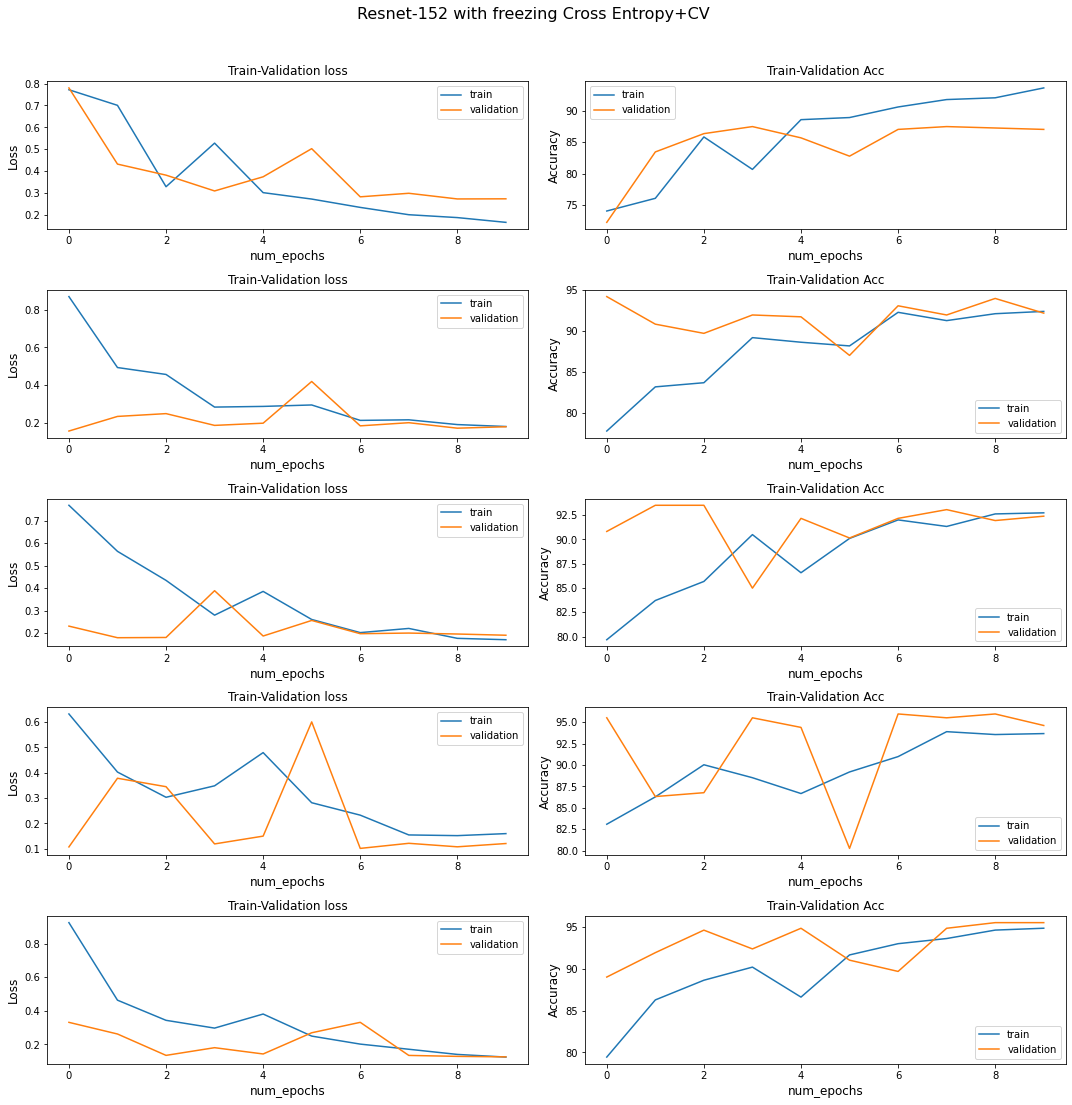

In [25]:
fold_plot(folderperf,k,"Resnet-152 with freezing Cross Entropy+CV ")

In [26]:
loss_func=F.cross_entropy
test_loss,test_acc=test(model,device,test_dl,test_ds,loss_func)
print("Resnet152 - with freezing cross entropy + CV")
print("Test Loss : {:.2f} \t Test Accuracy : {:.2f}".format(test_loss,test_acc))

Resnet152 - with freezing cross entropy + CV
Test Loss : 0.17 	 Test Accuracy : 93.98


### Focal Loss

In [27]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [28]:
# Parameters
num_classes=2
epochs = 20
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
loss_func=F.cross_entropy
gamma=2
alpha=0.25
k=5



In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_func=FocalLoss(gamma=gamma,alpha=alpha)
splits=KFold(n_splits=k,shuffle=True,random_state=42)

In [30]:
model=RESNET_152(num_classes)
to_device(model,device)

RESNET_152(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

Fold 1
FocalLoss()


  0%|          | 0/90 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


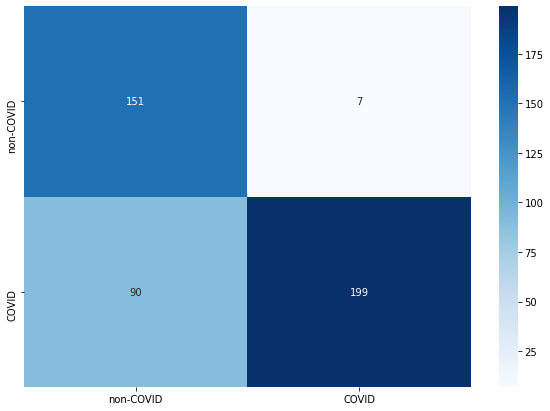

Epoch:1/10 AVG Training Loss:0.394 AVG Test Loss:0.052 AVG Training Acc 70.14 % AVG Test Acc 78.30 %


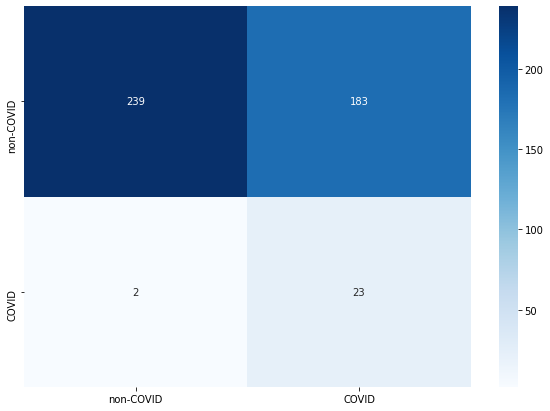

Epoch:2/10 AVG Training Loss:0.145 AVG Test Loss:0.575 AVG Training Acc 75.41 % AVG Test Acc 58.61 %


Epoch:3/10 AVG Training Loss:0.148 AVG Test Loss:0.102 AVG Training Acc 78.82 % AVG Test Acc 76.73 %


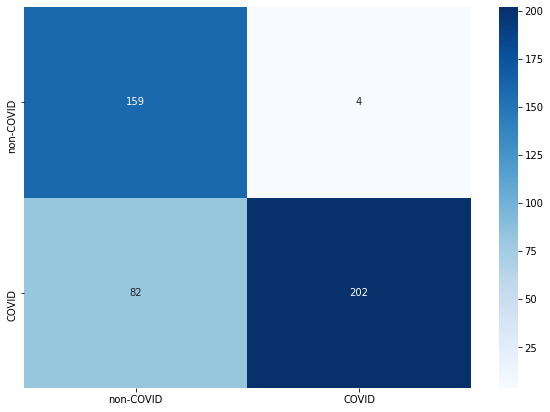

Epoch:4/10 AVG Training Loss:0.089 AVG Test Loss:0.077 AVG Training Acc 84.15 % AVG Test Acc 80.76 %


Epoch:5/10 AVG Training Loss:0.082 AVG Test Loss:0.345 AVG Training Acc 82.75 % AVG Test Acc 71.14 %


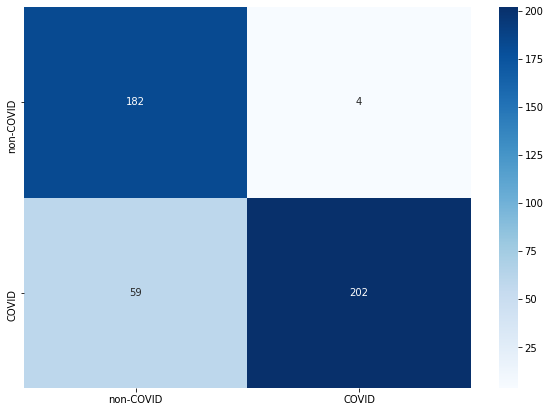

Epoch:6/10 AVG Training Loss:0.067 AVG Test Loss:0.048 AVG Training Acc 86.05 % AVG Test Acc 85.91 %


Epoch:7/10 AVG Training Loss:0.038 AVG Test Loss:0.040 AVG Training Acc 89.13 % AVG Test Acc 87.25 %


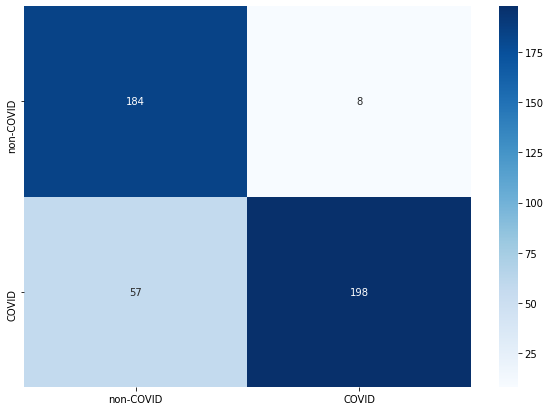

Epoch:8/10 AVG Training Loss:0.034 AVG Test Loss:0.045 AVG Training Acc 89.86 % AVG Test Acc 85.46 %


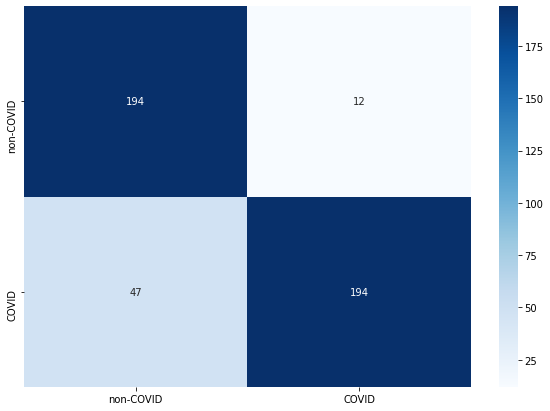

Epoch:9/10 AVG Training Loss:0.022 AVG Test Loss:0.038 AVG Training Acc 92.32 % AVG Test Acc 86.80 %


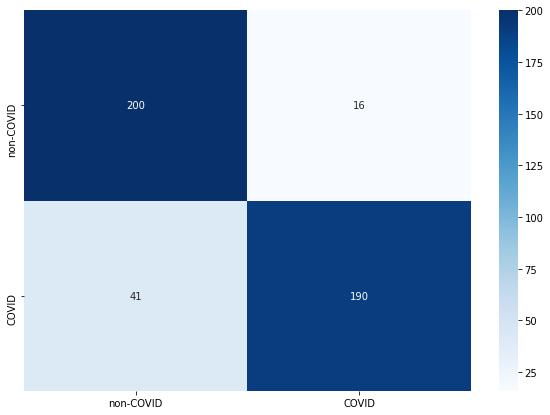

Epoch:10/10 AVG Training Loss:0.025 AVG Test Loss:0.038 AVG Training Acc 91.15 % AVG Test Acc 87.25 %
Fold 2
FocalLoss()


  0%|          | 0/90 [00:00<?, ?it/s]

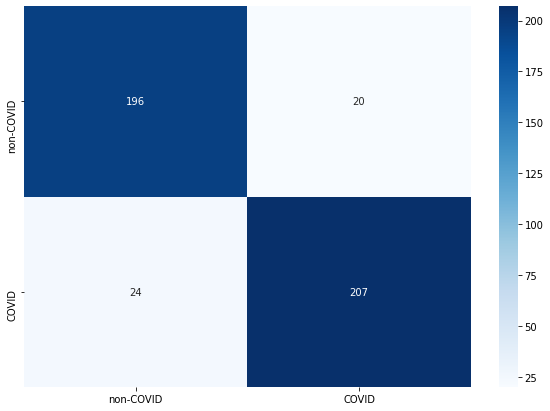

Epoch:1/10 AVG Training Loss:0.243 AVG Test Loss:0.060 AVG Training Acc 77.70 % AVG Test Acc 90.16 %


Epoch:2/10 AVG Training Loss:0.160 AVG Test Loss:0.205 AVG Training Acc 80.78 % AVG Test Acc 72.93 %


Epoch:3/10 AVG Training Loss:0.153 AVG Test Loss:0.365 AVG Training Acc 81.85 % AVG Test Acc 73.38 %


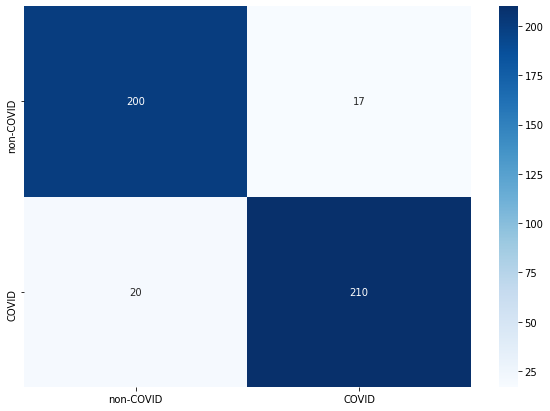

Epoch:4/10 AVG Training Loss:0.136 AVG Test Loss:0.061 AVG Training Acc 83.47 % AVG Test Acc 91.72 %


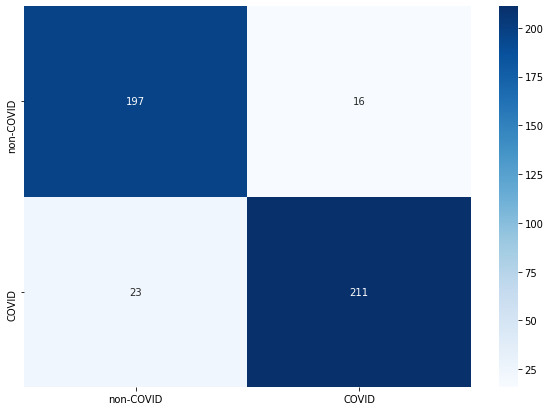

Epoch:5/10 AVG Training Loss:0.166 AVG Test Loss:0.074 AVG Training Acc 81.06 % AVG Test Acc 91.28 %


Epoch:6/10 AVG Training Loss:0.077 AVG Test Loss:0.055 AVG Training Acc 88.35 % AVG Test Acc 89.49 %


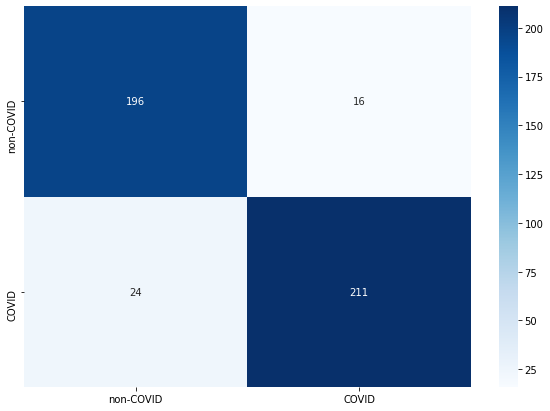

Epoch:7/10 AVG Training Loss:0.056 AVG Test Loss:0.055 AVG Training Acc 89.02 % AVG Test Acc 91.05 %


Epoch:8/10 AVG Training Loss:0.056 AVG Test Loss:0.049 AVG Training Acc 89.30 % AVG Test Acc 92.17 %


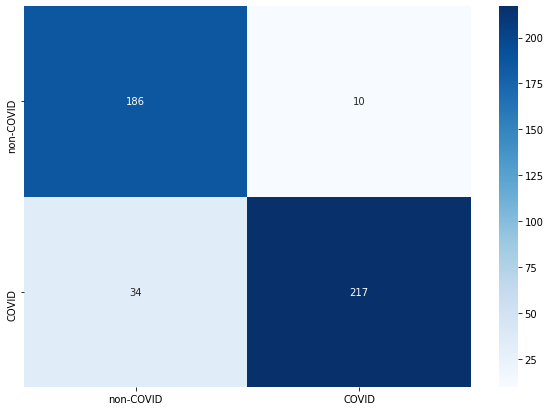

Epoch:9/10 AVG Training Loss:0.043 AVG Test Loss:0.049 AVG Training Acc 91.04 % AVG Test Acc 90.16 %


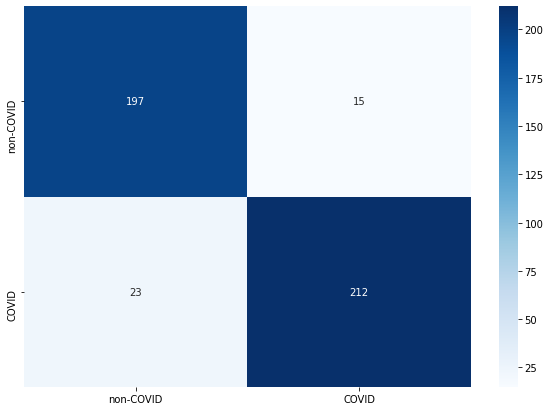

Epoch:10/10 AVG Training Loss:0.041 AVG Test Loss:0.046 AVG Training Acc 90.59 % AVG Test Acc 91.50 %
Fold 3
FocalLoss()


  0%|          | 0/90 [00:00<?, ?it/s]

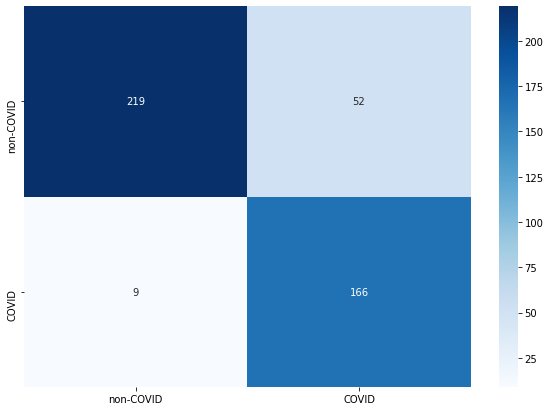

Epoch:1/10 AVG Training Loss:0.248 AVG Test Loss:0.137 AVG Training Acc 81.80 % AVG Test Acc 86.32 %


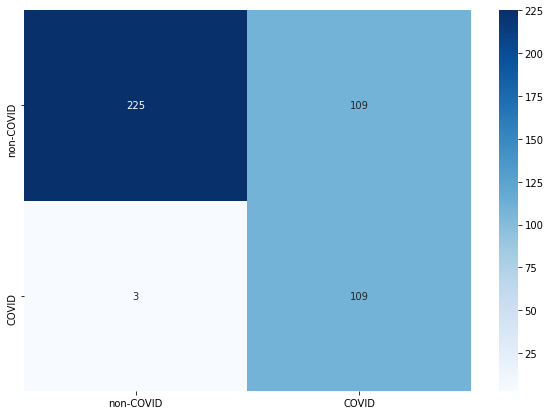

Epoch:2/10 AVG Training Loss:0.141 AVG Test Loss:0.414 AVG Training Acc 83.03 % AVG Test Acc 74.89 %


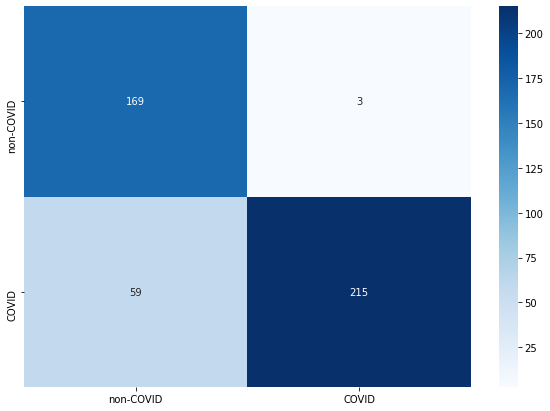

Epoch:3/10 AVG Training Loss:0.183 AVG Test Loss:0.110 AVG Training Acc 83.48 % AVG Test Acc 86.10 %


Epoch:4/10 AVG Training Loss:0.188 AVG Test Loss:0.133 AVG Training Acc 80.57 % AVG Test Acc 87.67 %


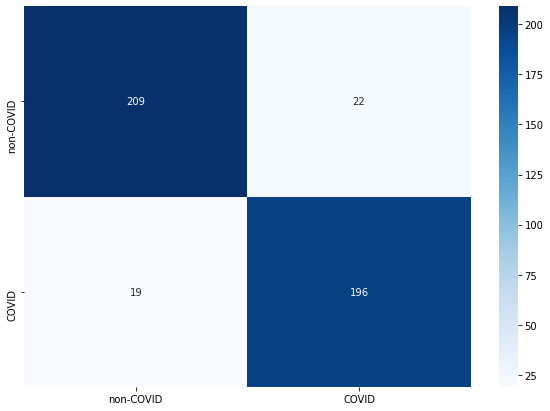

Epoch:5/10 AVG Training Loss:0.143 AVG Test Loss:0.091 AVG Training Acc 84.32 % AVG Test Acc 90.81 %


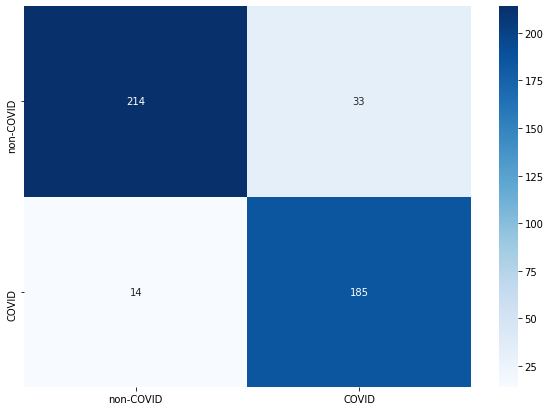

Epoch:6/10 AVG Training Loss:0.173 AVG Test Loss:0.124 AVG Training Acc 83.20 % AVG Test Acc 89.46 %


Epoch:7/10 AVG Training Loss:0.052 AVG Test Loss:0.080 AVG Training Acc 91.32 % AVG Test Acc 90.13 %


Epoch:8/10 AVG Training Loss:0.063 AVG Test Loss:0.083 AVG Training Acc 90.76 % AVG Test Acc 90.36 %


Epoch:9/10 AVG Training Loss:0.052 AVG Test Loss:0.072 AVG Training Acc 90.54 % AVG Test Acc 91.70 %


Epoch:10/10 AVG Training Loss:0.045 AVG Test Loss:0.075 AVG Training Acc 91.71 % AVG Test Acc 90.58 %
Fold 4
FocalLoss()


  0%|          | 0/90 [00:00<?, ?it/s]

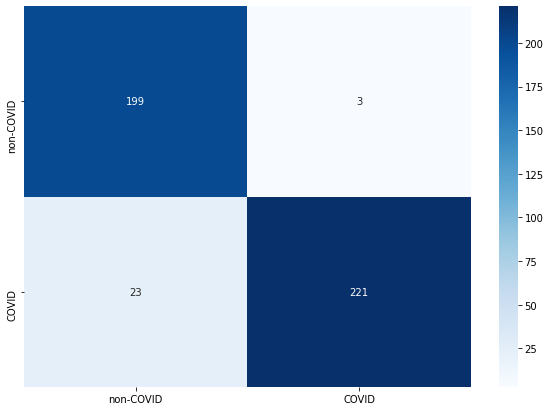

Epoch:1/10 AVG Training Loss:0.308 AVG Test Loss:0.028 AVG Training Acc 83.54 % AVG Test Acc 94.17 %


Epoch:2/10 AVG Training Loss:0.133 AVG Test Loss:0.062 AVG Training Acc 86.06 % AVG Test Acc 89.24 %


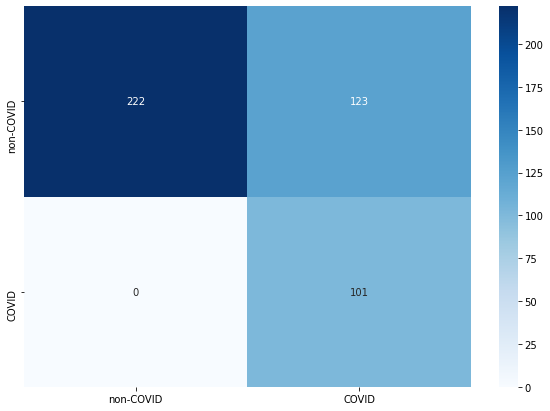

Epoch:3/10 AVG Training Loss:0.240 AVG Test Loss:0.601 AVG Training Acc 81.75 % AVG Test Acc 72.42 %


Epoch:4/10 AVG Training Loss:0.249 AVG Test Loss:0.057 AVG Training Acc 81.63 % AVG Test Acc 91.70 %


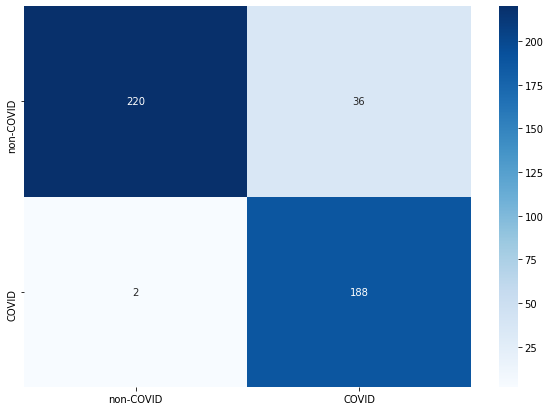

Epoch:5/10 AVG Training Loss:0.098 AVG Test Loss:0.115 AVG Training Acc 89.36 % AVG Test Acc 91.48 %


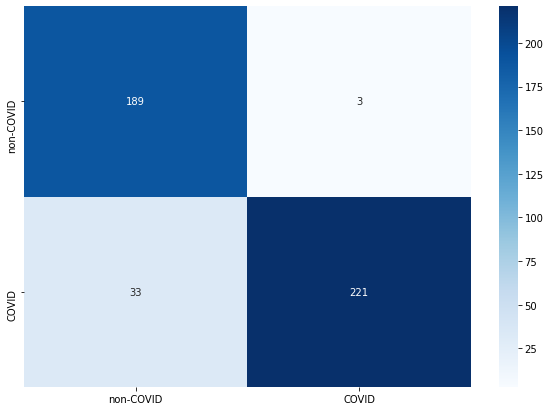

Epoch:6/10 AVG Training Loss:0.099 AVG Test Loss:0.042 AVG Training Acc 88.02 % AVG Test Acc 91.93 %


Epoch:7/10 AVG Training Loss:0.123 AVG Test Loss:0.040 AVG Training Acc 86.56 % AVG Test Acc 93.72 %


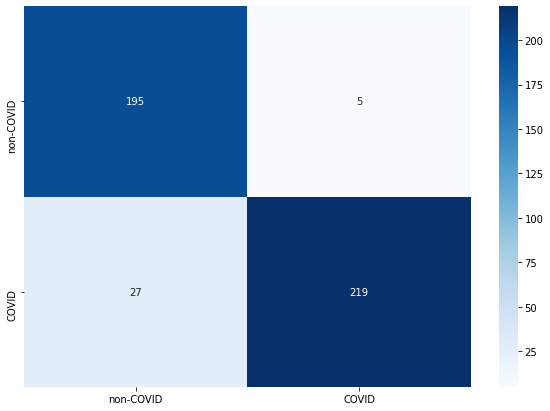

Epoch:8/10 AVG Training Loss:0.077 AVG Test Loss:0.038 AVG Training Acc 89.08 % AVG Test Acc 92.83 %


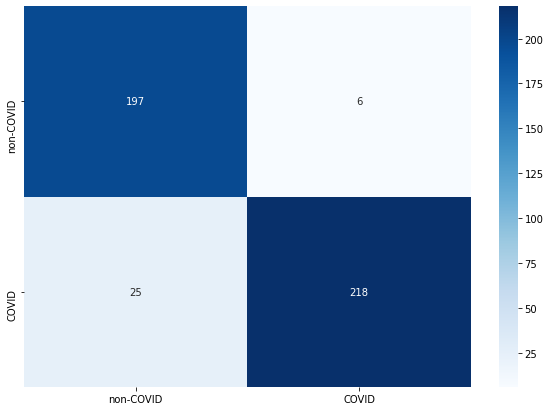

Epoch:9/10 AVG Training Loss:0.050 AVG Test Loss:0.038 AVG Training Acc 91.27 % AVG Test Acc 93.05 %


Epoch:10/10 AVG Training Loss:0.059 AVG Test Loss:0.036 AVG Training Acc 91.04 % AVG Test Acc 94.17 %
Fold 5
FocalLoss()


  0%|          | 0/90 [00:00<?, ?it/s]

Epoch:1/10 AVG Training Loss:0.175 AVG Test Loss:0.058 AVG Training Acc 83.82 % AVG Test Acc 91.93 %


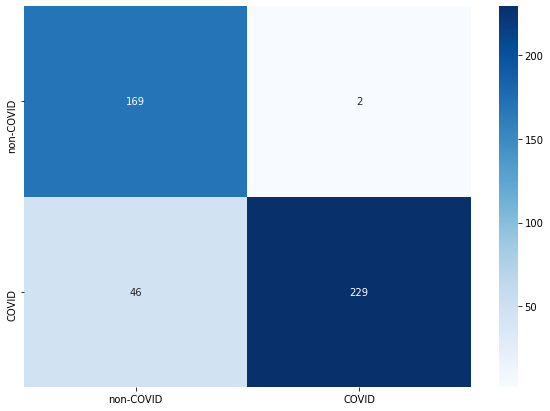

Epoch:2/10 AVG Training Loss:0.242 AVG Test Loss:0.100 AVG Training Acc 83.15 % AVG Test Acc 89.24 %


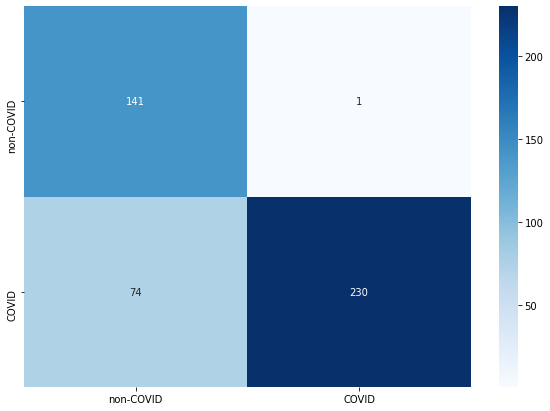

Epoch:3/10 AVG Training Loss:0.215 AVG Test Loss:0.210 AVG Training Acc 83.76 % AVG Test Acc 83.18 %


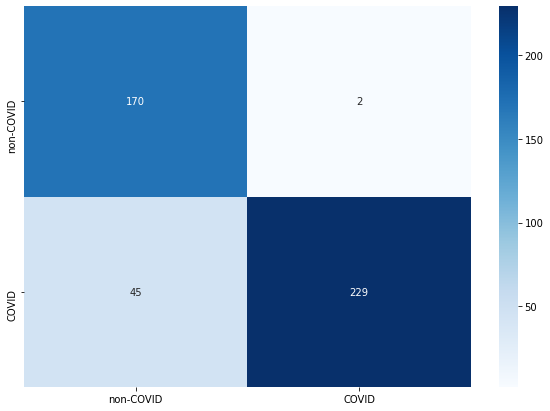

Epoch:4/10 AVG Training Loss:0.150 AVG Test Loss:0.093 AVG Training Acc 87.74 % AVG Test Acc 89.46 %


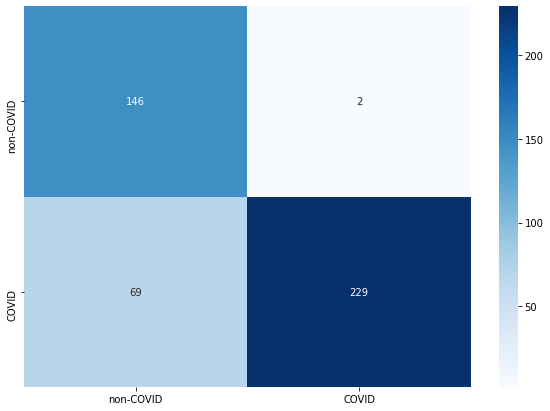

Epoch:5/10 AVG Training Loss:0.115 AVG Test Loss:0.144 AVG Training Acc 87.96 % AVG Test Acc 84.08 %


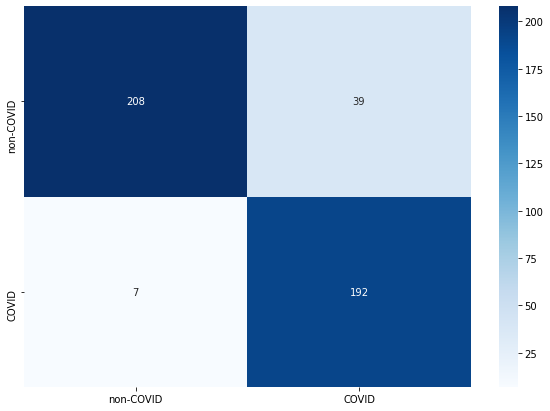

Epoch:6/10 AVG Training Loss:0.090 AVG Test Loss:0.167 AVG Training Acc 89.36 % AVG Test Acc 89.69 %


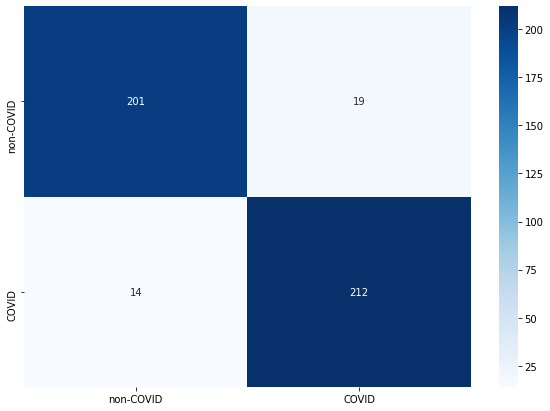

Epoch:7/10 AVG Training Loss:0.088 AVG Test Loss:0.066 AVG Training Acc 89.92 % AVG Test Acc 92.60 %


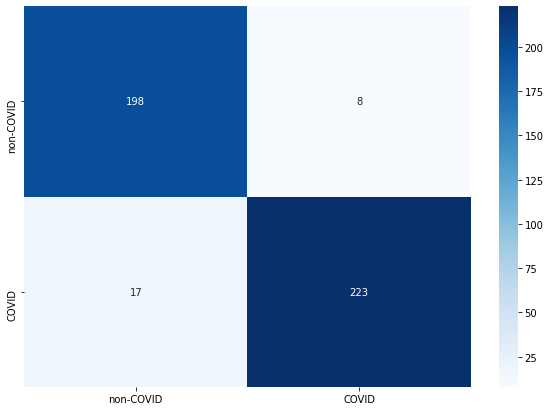

Epoch:8/10 AVG Training Loss:0.063 AVG Test Loss:0.055 AVG Training Acc 90.48 % AVG Test Acc 94.39 %


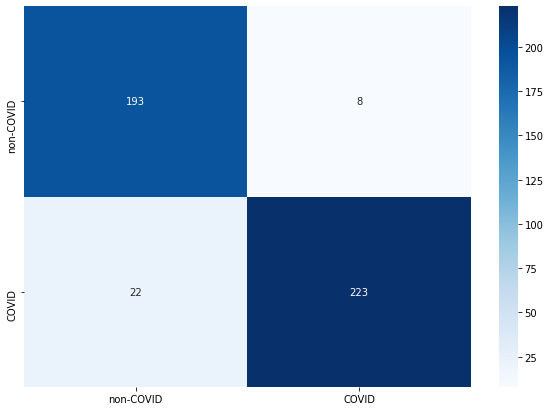

Epoch:9/10 AVG Training Loss:0.047 AVG Test Loss:0.052 AVG Training Acc 92.55 % AVG Test Acc 93.27 %


Epoch:10/10 AVG Training Loss:0.040 AVG Test Loss:0.054 AVG Training Acc 92.83 % AVG Test Acc 94.17 %


In [31]:
folderperf=cross_validate(model,num_classes,full_ds,opt_func,loss_func,grad_clip)

In [32]:
print("Resnet-152  With Freezing Focal Loss+CV ")
cv_results(folderperf)

Resnet-152  With Freezing Focal Loss+CV 
Performance of 5 fold cross validation
Average Training Loss: 0.122 	 Average val Loss: 0.115 	 Average Training Acc: 86.07 	 Average val Acc: 87.14
Max Training Acc: 92.83 	 Max val Acc: 94.39


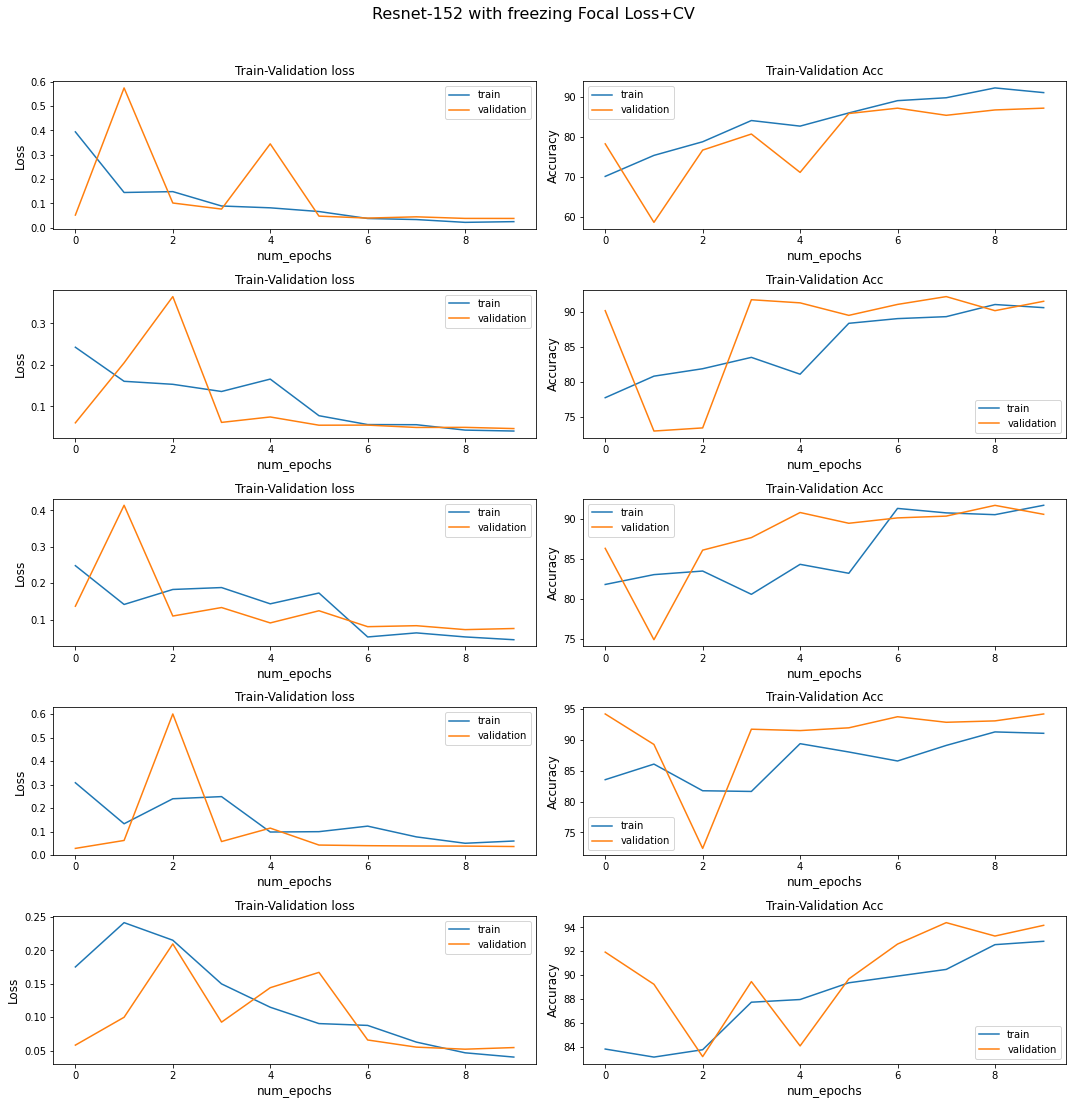

In [33]:
fold_plot(folderperf,k,"Resnet-152 with freezing Focal Loss+CV ")

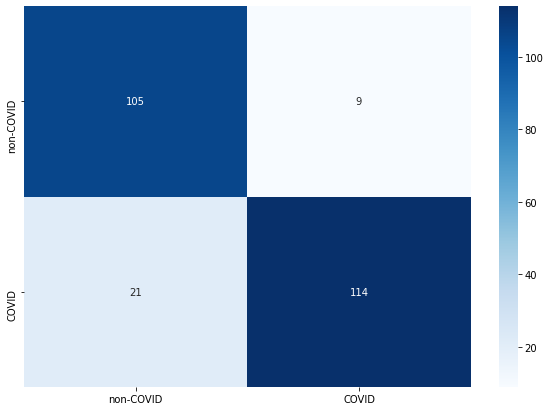

Resnet152 - with freezing focal loss + CV
Test Loss : 0.28 	 Test Accuracy : 87.95


In [34]:
loss_func=FocalLoss(gamma=gamma,alpha=alpha)
test_loss,test_acc=test(model,device,test_dl,test_ds,loss_fn=F.cross_entropy)
print("Resnet152 - with freezing focal loss + CV")
print("Test Loss : {:.2f} \t Test Accuracy : {:.2f}".format(test_loss,test_acc))